# II - Equilibrium calculations

### Equilibrium explanations

**Equilibrium calculations** are usually performed to obtain the adiabatic flame temperature, the equilibrium composition, and the thermodynamic state of a specific mixture under given conditions. These are virtually performed in every simulation.<br>
For example, Cantera will call its equilibrium solver to initialize the gas state before trying to obtain a solution to the equations for a free flame. As such, it is interesting to understand how Cantera proceeds.

There are 2 different types of solver currently implemented for equilibrium calculation in Cantera that
deserves our attention :
- **The element potential 'ChemEquil' solver**<br>
The class ChemEquil implements a chemical equilibrium solver for single-phase solutions. It is a
"non-stoichiometric" solver in the terminology of Smith and Missen, meaning that every intermediate
state is a valid chemical equilibrium state, but does not necessarily satisfy the element constraints.
<br>
Non-stoichiometric methods are faster when they converge, but stoichiometric ones tend to be more
robust.
- **The 'VCS' chemical equilibrium solver**<br>
The other type of solver is designed to be used to set a mixture containing one or more phases to
a state of chemical equilibrium. It uses a "stoichiometric" algorithm, in which each intermediate
state satisfies the element constraints but is not a state of chemical equilibrium. 
<br>
More specifically, it
implements the VCS algorithm, described in Smith and Missen, "Chemical Reaction Equilibrium". It
finds a set of component species and a complete set of formation reactions for the non-components in
terms of the components.

As expected, the **ChemEquil solver is the fastest** of the Cantera equilibrium solvers for many single-
phase equilibrium problems (particularly if there are only a few elements but very many species), **but
can be less stable**. <br>
Problem situations include low temperatures where only a few species have non-zero
mole fractions, precisely stoichiometric compositions (we will see an example shortly). In general, if
speed is important, this solver should always be tried first before falling back to another one in case of
failure.

### The function equilibrate

The default setting in Cantera, when launching an equilibrium calculation without specifying
the solver, is to try the 'element potential' before falling back to another vcs solver labelled 'gibbs' :
<code>
gas.equilibrate('TP')
</code>

The equilibrate function can be applied on a single phase or on a mixture. Here, we recall its definition:
<code>
equilibrate(self, XY, solver, double rtol, int maxsteps, int maxiter, int loglevel)
</code>
<br>
Parameters:
<code>
XY                - A two-letter string, which must be one of the set: ['TP','TV','HP','SP','SV','UV'].
solver            - Specifies the equilibrium solver to use. May be one of the following :
    element_potential = A fast solver using the element potential method.
    gibbs             = A slower but more robust Gibbs minimization solver.
    vcs               = The VCS non-ideal equilibrium solver.
    auto              = The element potential solver will be tried first, then if it fails the gibbs solver will be
                        tried.
rtol              - The relative error tolerance.
maxsteps          - Maximum number of steps in composition to take to find a converged solution.
maxiter           - This specifies the number of outer iterations on T or P when some property pair other than TP is
                    specified (only for 'gibbs').
loglevel          - Is currently deprecated.
</code>


### Useful python imports

In [1]:
import cantera as ct
import numpy as np
import csv
from matplotlib import *
import matplotlib.pyplot as plt
import sys

## 1. Simple homogeneous equilibrium of a gas

<div class="alert alert-danger "><b> Please create the gas object so that :<br>
- the mechanism used is the gri30<br>
- this is an air/CH4 mix<br>
- the mix is at stoichiometry<br>
- the temperature is 300K and the pressure 1 bar.
<b></div>

In [2]:
gas = ct.Solution('gri30.cti')           # create an object representing the gas phase

gas.TPX = 300, 100000,{'CH4':1, 'O2':2, 'N2':7.52}      # set initial state

gas.equilibrate('TP')                 # equilibrate using Temperature (T) and Pressure (P)

print(gas())


  gri30:

       temperature             300  K
          pressure          100000  Pa
           density         1.10784  kg/m^3
  mean mol. weight         27.6332  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -3.0153e+06       -8.332e+07     J
   internal energy     -3.1056e+06       -8.582e+07     J
           entropy            7234        1.999e+05     J/K
    Gibbs function     -5.1855e+06       -1.433e+08     J
 heat capacity c_p          1111.3        3.071e+04     J/K
 heat capacity c_v          810.42        2.239e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
               H2O       0.190114         0.123943         -121.334
               CO2       0.095057         0.151392         -185.839
                N2       0.714829         0.724665          -23.382
     [  +50 minor]     2.5

As you see, the gas has been equilibrated since it now shows only quantities for the product of the reaction (H2O and CO2). You can try to set yourself out of the perfect mixing (for example set CH4 to 0.4 and to 0.6) and see the impact on the species in the mix at the end.

## 2. Failure of a solver

Cantera has 3 different equilibrium solvers, 2 of them are worth mentionning: 
- The 'ChemEquil' solver uses the element potential method for homogeneous equilibrium in gas mixtures. It is fast, but sometimes doesn't converge. 
- The 'VCS' solver uses the VCS algorithm (Gibbs minimization), which is slower but more robust. It can also handle multiple phases.<br>
Here we'll solve a problem for which the ChemEquil solver fails, but the VCS solver has no problem.

### Properties of the gas

In [3]:
pressure = 1.0e5                # pressure
temperature = 400.0             # unburned gas temperature
comp = 'CH4:0.5, O2:1, N2:3.76' # premixed gas composition

gas = ct.Solution('gri30.xml')
gas.TPX = temperature, pressure, comp

### Initial state of the gas

In [4]:
print("******************************************************** ")
print("    Initial state :")
print("******************************************************** ")
print("P =  ", "%10.4e  " % (gas.P) + "    Pa")
print("T =  ", "%10.4e  " % (gas.T) + "    K")
print("V =  ", "%10.4e  " % (gas.volume_mass) + "    m3/kg")
print("U =  ", "%10.4e  " % (gas.int_energy_mass) + "    J/kg")
print("H =  ", "%10.4e  " % (gas.enthalpy_mass) + "    J/kg")
print("S =  ", "%10.4e  " % (gas.entropy_mass) + "    J/kg/K")
print("")
print("")

******************************************************** 
    Initial state :
******************************************************** 
P =   1.0000e+05      Pa
T =   4.0000e+02      K
V =   1.2035e+00      m3/kg
U =   -2.6590e+05      J/kg
H =   -1.4554e+05      J/kg
S =   7.5652e+03      J/kg/K




### Comparing chemical potentials and element potentials

Here, the chemical potentials (noted mu_xx) are compared to the corresponding calculated values with the element potentials (noted lambda_xx).<br>
For instance, mu_H2 = lambda_H x 2.<br>
This is a good way to check whether the solver has managed to compute the results correctly. The chemical potentials are the one of the vapor phase.

In [5]:
chemeq = np.zeros(gas.n_species)
chemeq = gas.chemical_potentials

mu_H2 = chemeq[gas.species_index("H2")]
mu_OH = chemeq[gas.species_index("OH")]
mu_H2O = chemeq[gas.species_index("H2O")]
mu_O2 = chemeq[gas.species_index("O2")]
lambda_H = chemeq[gas.species_index("H")]
lambda_O = chemeq[gas.species_index("O")]

print()
print("Comparison between Chem potentials and element potentials:")
print()
s_mu_H2 = "%11.4e" % mu_H2
s_lam_mu_H2 = "%11.4e" % (2.0 * lambda_H)
print("mu_H2   : ", s_mu_H2, ",    ", s_lam_mu_H2)

s_mu_O2 = "%11.4e" % mu_O2
s_lam_mu_O2 = "%11.4e" % (2.0 * lambda_O)
print("mu_O2   : ", s_mu_O2, ",    ", s_lam_mu_O2)

s_mu_OH = "%11.4e" % mu_OH
s_lam_mu_OH = "%11.4e" % (lambda_H + lambda_O)
print("mu_OH   : ", s_mu_OH, ",    ", s_lam_mu_OH)

s_mu_H2O = "%11.4e" % mu_H2O
s_lam_mu_H2O = "%11.4e" % (2.0 * lambda_H + lambda_O)
print("mu_H2O  : ", s_mu_H2O, ",    ", s_lam_mu_H2O)


Comparison between Chem potentials and element potentials:

mu_H2   :  -2.3501e+09 ,     -4.2513e+09
mu_O2   :  -8.8089e+07 ,     -4.2260e+09
mu_OH   :  -2.3320e+09 ,     -4.2386e+09
mu_H2O  :  -2.6153e+09 ,     -6.3643e+09


### Program equilibrate

In [6]:
try:
    # print("0")
    gas.equilibrate('TP', solver='element_potential')  # use the ChemEquil solver
except:
    print("")
    print("ChemEquil solver failed! Trying the vcs solver...")
    gas.equilibrate('TP', solver='vcs', maxsteps=1500)
    # gas.equilibrate('TP', solver = 'gibbs')              # the gibbs solver works also


ChemEquil solver failed! Trying the vcs solver...


### Compare the results with the initial values

In [11]:
print("")
print("******************************************************** ")
print("    Final state :")
print("    Tadiabatique = " + str(gas.T) + " K")
print("******************************************************** ")
print("P =  ", "%10.4e  " % (gas.P) + "    Pa")
print("T =  ", "%10.4e  " % (gas.T) + "    K")
print("V =  ", "%10.4e  " % (gas.volume_mass) + "    m3/kg")
print("U =  ", "%10.4e  " % (gas.int_energy_mass) + "    J/kg")
print("H =  ", "%10.4e  " % (gas.enthalpy_mass) + "    J/kg")
print("S =  ", "%10.4e  " % (gas.entropy_mass) + "    J/kg/K")
print("")
print("")


******************************************************** 
    Final state :
    Tadiabatique = 400.0 K
******************************************************** 
P =   1.0000e+05      Pa
T =   4.0000e+02      K
V =   1.2035e+00      m3/kg
U =   -3.0233e+06      J/kg
H =   -2.9029e+06      J/kg
S =   7.5571e+03      J/kg/K




### Comparing chemical and element equilibrium for the equilibrate mixture

In [12]:
chemeq = gas.chemical_potentials
mu_H2 = chemeq[gas.species_index("H2")]
mu_OH = chemeq[gas.species_index("OH")]
mu_H2O = chemeq[gas.species_index("H2O")]
mu_O2 = chemeq[gas.species_index("O2")]
lambda_H = chemeq[gas.species_index("H")]
lambda_O = chemeq[gas.species_index("O")]

print()
print("Comparison between Chem potentials and element potentials:")
print()
s_mu_H2 = "%11.4e" % mu_H2
s_lam_mu_H2 = "%11.4e" % (2.0 * lambda_H)
print("mu_H2   : ", s_mu_H2, ",    ", s_lam_mu_H2)

s_mu_O2 = "%11.4e" % mu_O2
s_lam_mu_O2 = "%11.4e" % (2.0 * lambda_O)
print("mu_O2   : ", s_mu_O2, ",    ", s_lam_mu_O2)

s_mu_OH = "%11.4e" % mu_OH
s_lam_mu_OH = "%11.4e" % (lambda_H + lambda_O)
print("mu_OH   : ", s_mu_OH, ",    ", s_lam_mu_OH)

s_mu_H2O = "%11.4e" % mu_H2O
s_lam_mu_H2O = "%11.4e" % (2.0 * lambda_H + lambda_O)
print("mu_H2O  : ", s_mu_H2O, ",    ", s_lam_mu_H2O)


Comparison between Chem potentials and element potentials:

mu_H2   :  -2.1760e+08 ,     -2.1760e+08
mu_O2   :  -2.1169e+08 ,     -2.1169e+08
mu_OH   :  -2.1465e+08 ,     -2.1465e+08
mu_H2O  :  -3.2345e+08 ,     -3.2345e+08


### Saving the results

In [13]:
csv_file = '2-Output/all_mole_fractions.csv'
with open(csv_file, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['phi', 'T (K)'] + gas.species_names)
    writer.writerow(['1', gas.T] + list(gas.X))
print(('Output written to {0}'.format(csv_file)))

Output written to 2-Output/all_mole_fractions.csv


## 3. Perform adiabatic flame calculations as a function of equivalence ratio

### Set gas composition and interesting parameters

We will now perform **several constant pressure equilibrium calculations of an ethylene/air mixture, at
an initial temperature of 300K and under atmospheric pressure**, in order to obtain the adiabatic flame temperature and burnt gas state for several equivalence ratios.<br>
The goal of this exercise is to find a way to loop through several gaseous composition, in order to perform several computations in a single script; and to learn how to properly store the results in a *csv* file.

In [14]:
gas = ct.Solution('Mechanisms/mech.cti')

T = 300.0                     # Temperature
P = 101325.0                  # Pressure

phi_min = 0.3                 # Minimal equivalence ratio
phi_max = 3.5                 # Maximal equivalence ratio
npoints = 50                  # Point in-between the two preceeding values

fuel_species = 'C2H4'         # fuel species
air_N2_O2_molar_ratio = 3.76  # ratio representing the air



**** WARNING ****
For species C2H3O, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  26.0651
	Value computed using high-temperature polynomial: 11.7479


**** WARNING ****
For species C2H3O, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  13.2934
	Value computed using high-temperature polynomial: 9.71415


**** WARNING ****
For species C2H3O, discontinuity in s/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  47.9078
	Value computed using high-temperature polynomial: 43.1354


**** WARNING ****
For species C4H612, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  20.128
	Value computed using high-temperature polynomial: 20.1809


### Loop of equilibrium

In [15]:
phi = np.zeros(npoints)                  # 1D array
tad = np.zeros(npoints)                  # 1D array

xeq = np.zeros((gas.n_species, npoints)) # 2D array

for i in range(npoints):

    gas.TP = T, P
    
    phi[i] = phi_min + (phi_max - phi_min) * i / (npoints - 1)
    gas.set_equivalence_ratio(phi[i], {fuel_species: 1}, {'O2': 1, 'N2': air_N2_O2_molar_ratio})

    gas.equilibrate('HP') # Equilibrate the mixture adiabatically at constant P with the solver vcs
    
    xeq[:, i] = gas.X
    tad[i] = gas.T
    print("At phi = ","%10.4f"% (phi[i])+ "  Tad = ","%10.4f"% (tad[i]))

At phi =      0.3000  Tad =   1142.8447
At phi =      0.3653  Tad =   1300.2150
At phi =      0.4306  Tad =   1450.9493
At phi =      0.4959  Tad =   1595.5516
At phi =      0.5612  Tad =   1734.1502
At phi =      0.6265  Tad =   1866.3165
At phi =      0.6918  Tad =   1990.7250
At phi =      0.7571  Tad =   2104.7920
At phi =      0.8224  Tad =   2204.7841
At phi =      0.8878  Tad =   2286.8442
At phi =      0.9531  Tad =   2348.1575
At phi =      1.0184  Tad =   2386.8246
At phi =      1.0837  Tad =   2401.1649
At phi =      1.1490  Tad =   2391.6957
At phi =      1.2143  Tad =   2364.6794
At phi =      1.2796  Tad =   2328.6936
At phi =      1.3449  Tad =   2289.2479
At phi =      1.4102  Tad =   2248.8202
At phi =      1.4755  Tad =   2208.4207
At phi =      1.5408  Tad =   2168.4587
At phi =      1.6061  Tad =   2129.0955
At phi =      1.6714  Tad =   2090.3866
At phi =      1.7367  Tad =   2052.3409
At phi =      1.8020  Tad =   2014.9472
At phi =      1.8673  Tad =   1978.1865


### Save files

In [16]:
csv_file = '2-Output/yourfile.csv'
with open(csv_file, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Phi', 'T (K)'] + gas.species_names)
    for i in range(npoints):
        writer.writerow([phi[i], tad[i]] + list(xeq[:, i]))
print("Output written to", "%s" % csv_file)

Output written to 2-Output/yourfile.csv


### Plot the results

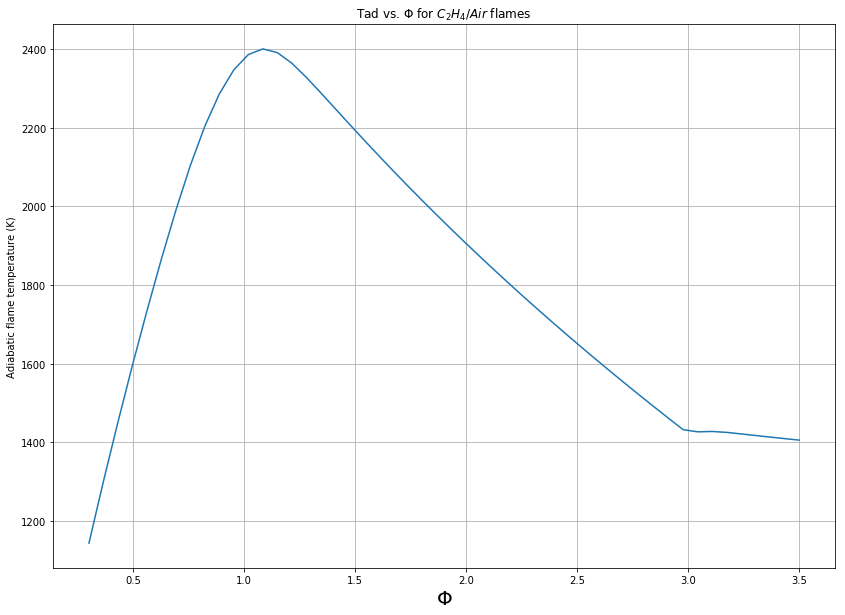

<Figure size 1008x720 with 0 Axes>

In [17]:
rcParams['figure.figsize'] = (14, 10)

plt.plot(phi, tad, '-')

plt.title(r'Tad vs. $\Phi$ for $C_{2}H_{4}/Air$ flames')
plt.xlabel(r'$\Phi$', fontsize=20)
plt.ylabel("Adiabatic flame temperature (K)")

plt.grid()

plt.show()
plt.savefig('2-Output/plot_tad.png', bbox_inches='tight')

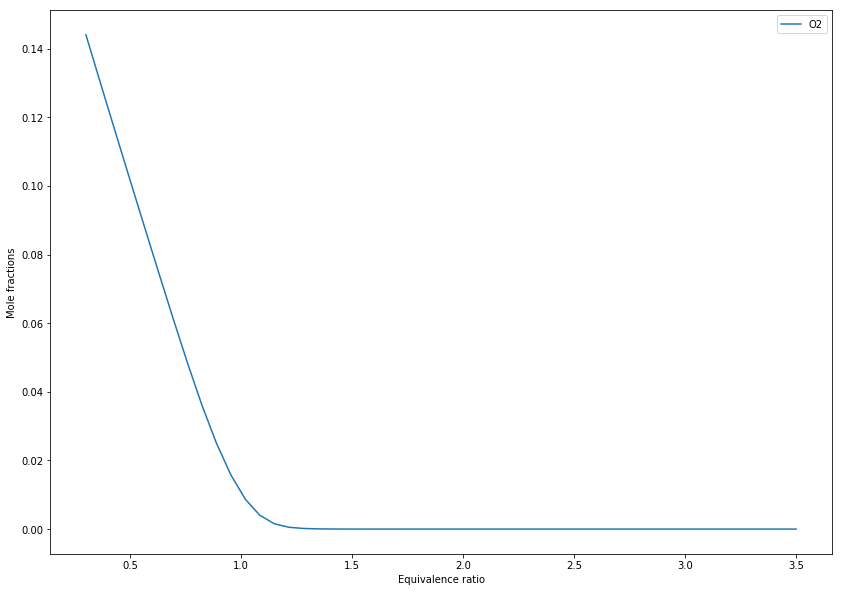

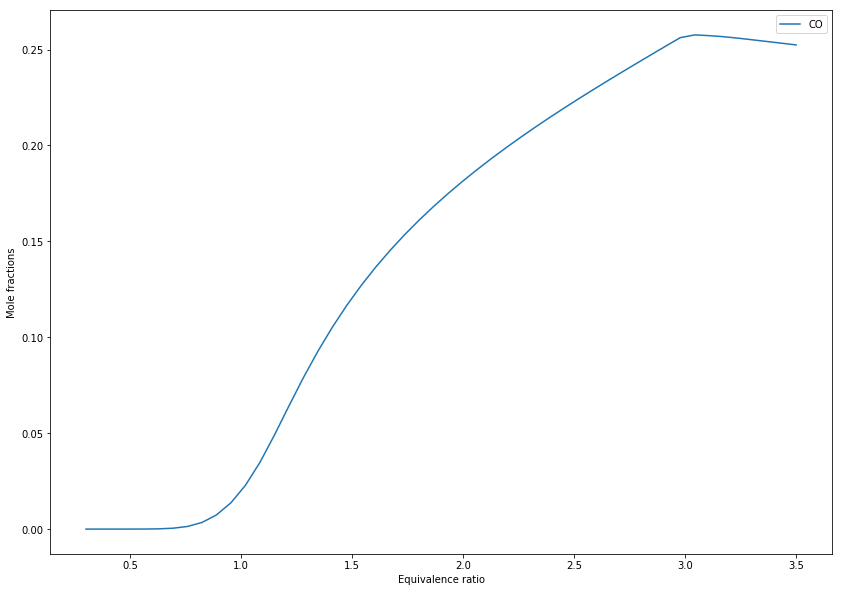

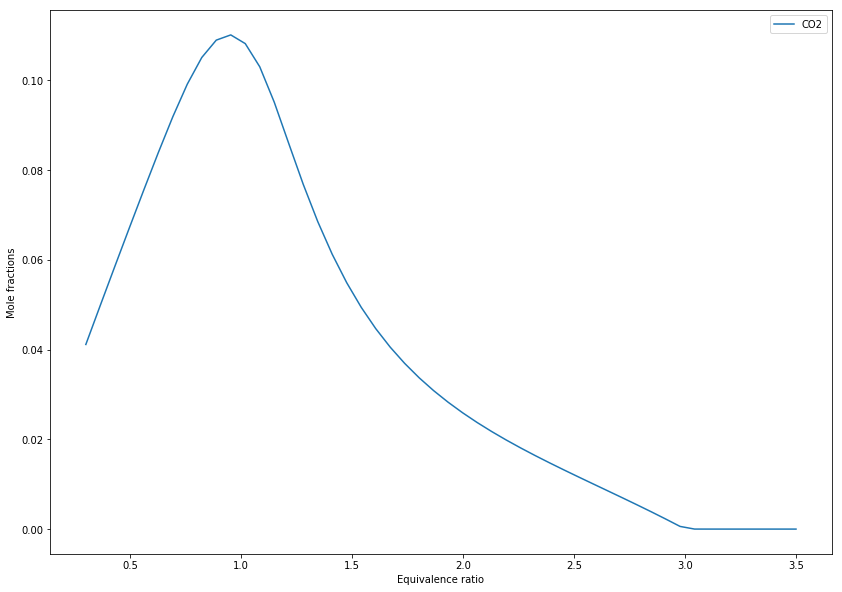

In [18]:
for i, cas in enumerate(gas.species_names):
    if cas in ['O2','CO2','CO']:
        plt.plot(phi,xeq[i,:], label = cas)
        plt.xlabel('Equivalence ratio')
        plt.ylabel('Mole fractions')
        plt.legend(loc='best')
        plt.show()

## Conclusion

We have just generated the skeleton of a script to perform a series of common equilibrium calculations
to obtain the constant pressure equilibrium composition of a fuel/air mixture. Starting from there,
you could modify your initial conditions, plot the mole/mass fractions of other species, change the
solver or even try another fuel (methane, acetylene) without changing your mechanism.<br>
Technically, adiabatic flame calculations could also be performed at constant volume: simply invoke
the good equilibrate option of your equilibrate function, 'UV' (see 3.1.2), in your script.